In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [19]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [3]:
print('Duplicates in train:', train.duplicated().sum())
print('Duplicates in test:', test.duplicated().sum())


Duplicates in train: 0
Duplicates in test: 0


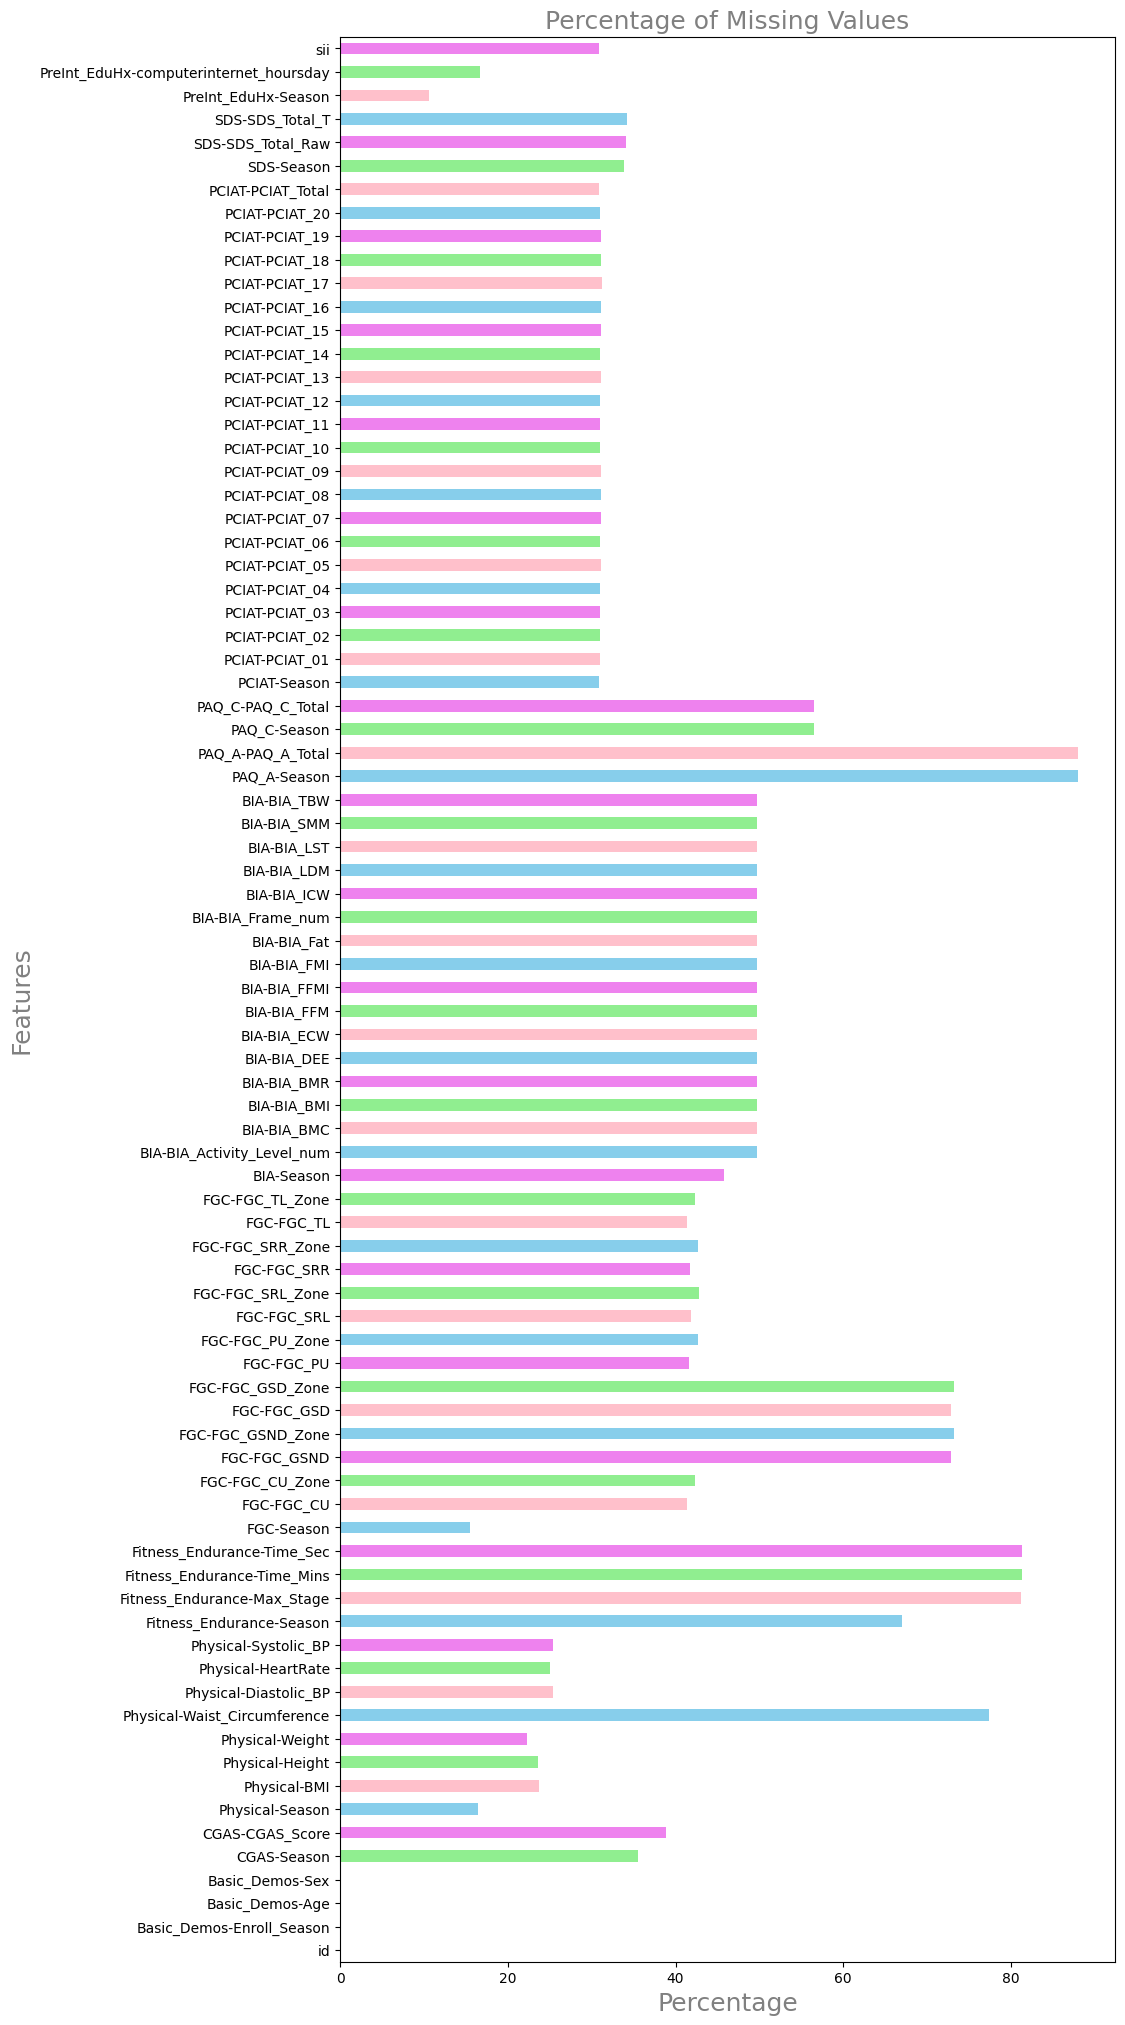

In [20]:
train_col = train.columns.tolist()
test_col = test.columns.tolist()

missing_values = train.isnull().mean() * 100
missing_values.plot(kind='barh', figsize=(10, 25), color=['lightgreen','violet','skyblue','pink'])

plt.title('Percentage of Missing Values', fontsize=18, color='gray')
plt.xlabel('Percentage', fontsize=18, color='gray')
plt.ylabel('Features', fontsize=18, color='gray')
plt.gca().set_facecolor('white')
plt.xticks(rotation=0)
plt.show();

Insights from Missing Values
Severely Missing Data:

Features like PAQ_A-PAQ_A_Total and PAQ_A-Season have 88% missing values, making them poor candidates for analysis unless they're critical to the model.
Moderately Missing Data:

Features like Fitness_Endurance-* are missing in ~81% of the rows. These may be retained if imputation or domain knowledge suggests their importance.
Low Missing Data:

Features like Physical-Season (16%) and Physical-Weight (22%) are manageable and can be imputed effectively.


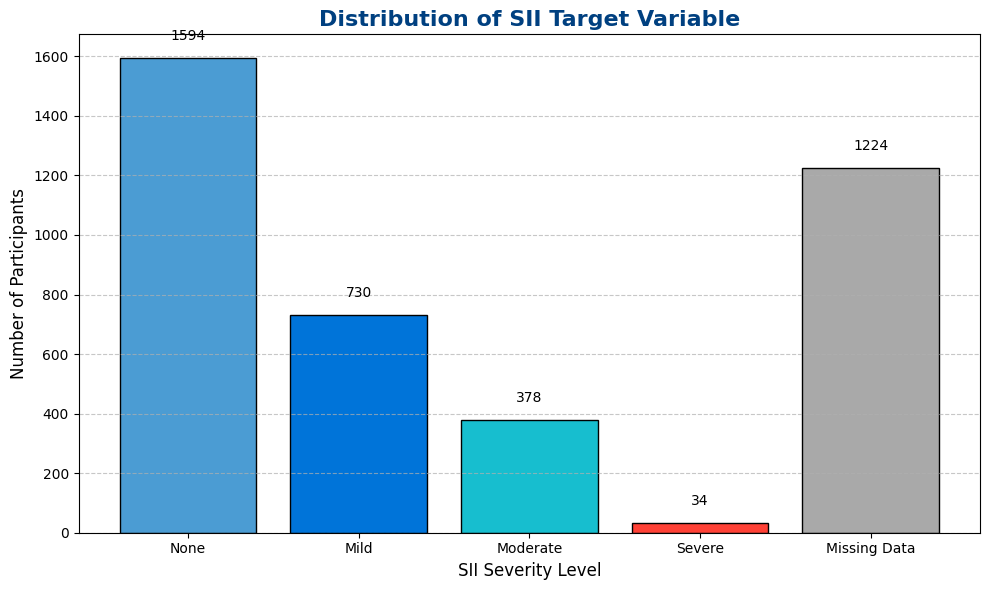

In [6]:


# Define the mapping for SII levels including "Missing" for NaNs
sii_map = {
    0: "None",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    "missing": "Missing Data"
}

# Replace NaN values with "missing" to count them as a separate category
train['sii_filled'] = train['sii'].fillna("missing")
train['sii_label'] = train['sii_filled'].map(sii_map)

# Count the occurrences for each SII level, including missing data
sii_counts = train['sii_label'].value_counts()
sii_percentages = (sii_counts / sii_counts.sum()) * 100

# Create DataFrame for plotting
sii_data = pd.DataFrame({
    'SII Level': sii_counts.index,
    'Count': sii_counts.values,
    'Percentage': sii_percentages.values
})

# Define colors for each SII level
colors = {
    "None": "#4B9CD3",        # Blue
    "Mild": "#0074D9",        # Darker Blue
    "Moderate": "#17BECF",    # Teal
    "Severe": "#FF4136",      # Red
    "Missing Data": "#A9A9A9" # Gray
}
sii_data['Color'] = sii_data['SII Level'].map(colors)

# Sort data for proper order
sii_data['SII Level'] = pd.Categorical(
    sii_data['SII Level'], 
    categories=["None", "Mild", "Moderate", "Severe", "Missing Data"], 
    ordered=True
)
sii_data = sii_data.sort_values('SII Level')

# Plot the data
plt.figure(figsize=(10, 6))
bars = plt.bar(sii_data['SII Level'], sii_data['Count'], color=sii_data['Color'], edgecolor='black')

# Annotate counts on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='bottom', fontsize=10)

# Customize plot appearance
plt.title("Distribution of SII Target Variable", fontsize=16, fontweight='bold', color="#004080")
plt.xlabel("SII Severity Level", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


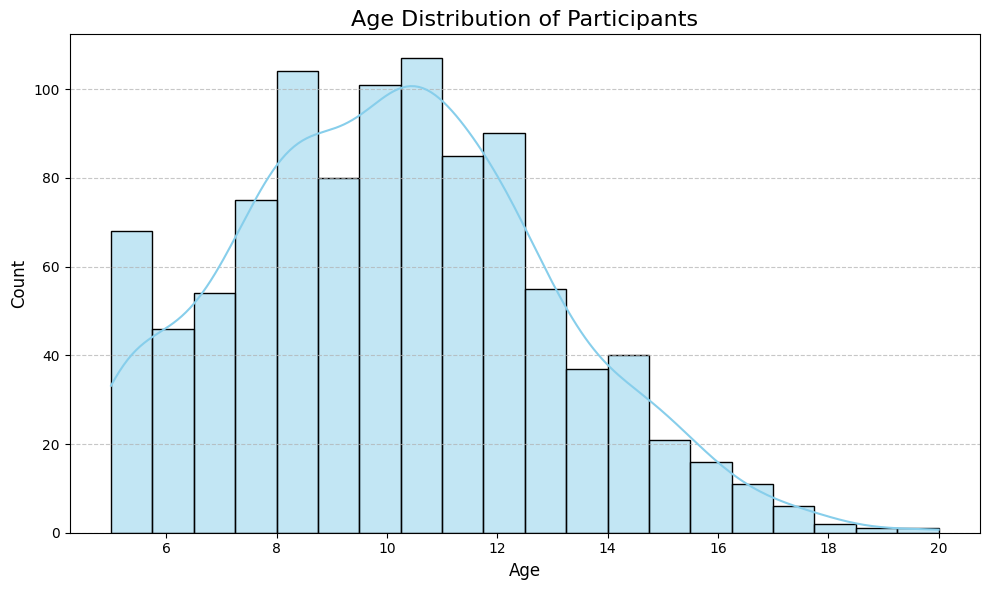

In [7]:
# Re-importing necessary libraries after environment reset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Simulate example data for "Basic_Demos-Age"
np.random.seed(42)
train = pd.DataFrame({
    'Basic_Demos-Age': np.random.normal(loc=10, scale=3, size=1000).clip(5, 20)
})

# Plot age distribution without points
plt.figure(figsize=(10, 6))
sns.histplot(train['Basic_Demos-Age'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title("Age Distribution of Participants", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


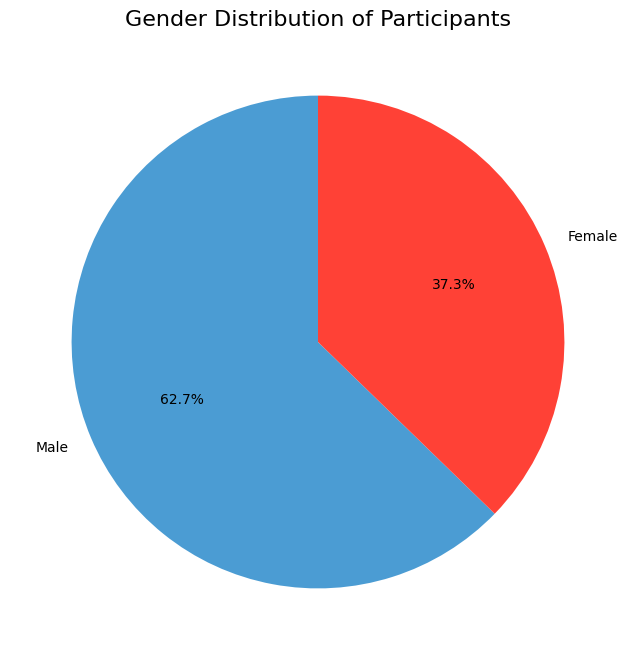

In [21]:
# Gender count
gender_counts = train['Basic_Demos-Sex'].value_counts()
gender_labels = ["Male", "Female"]

# Pie chart for gender distribution
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_labels, autopct='%1.1f%%', startangle=90, colors=['#4B9CD3', '#FF4136'])
plt.title("Gender Distribution of Participants", fontsize=16)
plt.show()



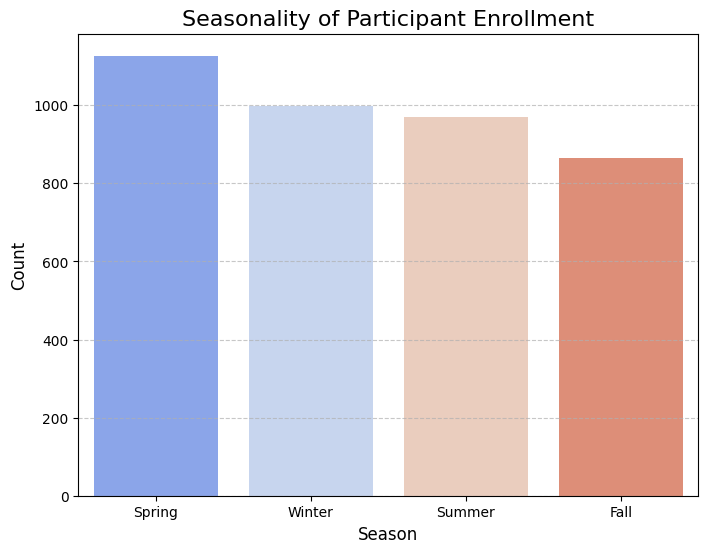

In [22]:
# Count enrollments by season
season_counts = train['Basic_Demos-Enroll_Season'].value_counts()

# Bar chart for enrollment seasonality
plt.figure(figsize=(8, 6))
sns.barplot(x=season_counts.index, y=season_counts.values, palette='coolwarm')
plt.title("Seasonality of Participant Enrollment", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Correlations with sii:
CGAS-CGAS_Score     -0.085261
PCIAT-PCIAT_Total    0.899681
SDS-SDS_Total_Raw    0.229692
Name: sii, dtype: float64


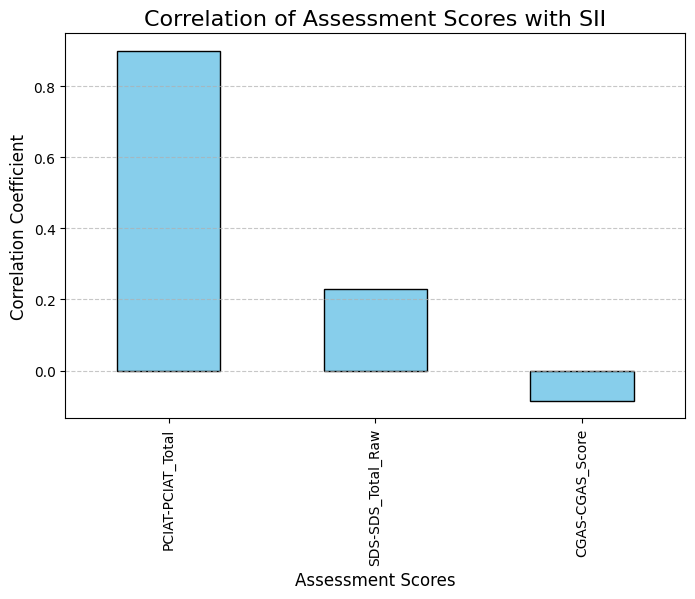

In [23]:
# Select relevant columns for correlation analysis
assessment_columns = ['CGAS-CGAS_Score', 'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw']

# Calculate correlation of these columns with `sii`
correlations = train[assessment_columns + ['sii']].corr()['sii'].drop('sii')
print("Correlations with sii:")
print(correlations)

# Plot correlation values
plt.figure(figsize=(8, 5))
correlations.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Correlation of Assessment Scores with SII", fontsize=16)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xlabel("Assessment Scores", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


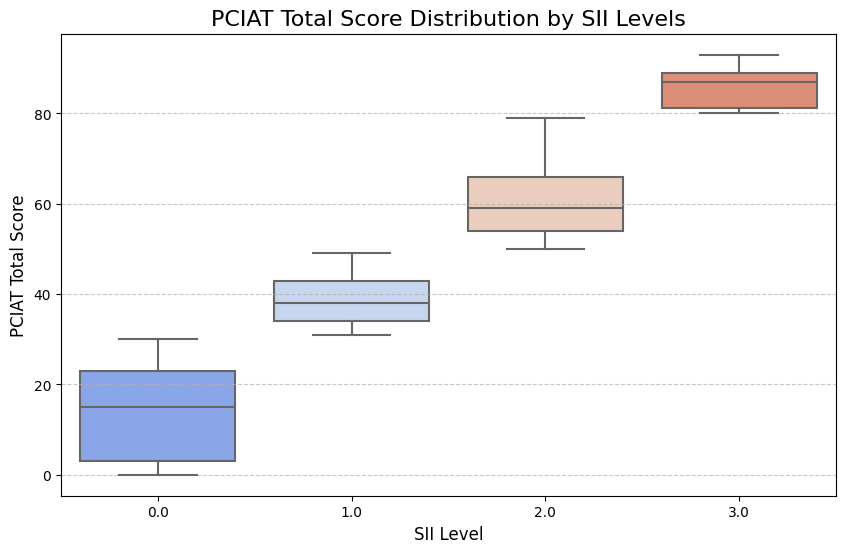

In [24]:
# Boxplot for PCIAT-PCIAT_Total vs. sii
plt.figure(figsize=(10, 6))
sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=train, palette='coolwarm')
plt.title("PCIAT Total Score Distribution by SII Levels", fontsize=16)
plt.xlabel("SII Level", fontsize=12)
plt.ylabel("PCIAT Total Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [25]:
# Check if SII_Category exists
if 'SII_Category' not in train.columns:
    sii_map = {
        0: "None",
        1: "Mild",
        2: "Moderate",
        3: "Severe",
        "missing": "Missing Data"
    }
    train['sii_filled'] = train['sii'].fillna("missing")  # Handle missing sii values
    train['SII_Category'] = train['sii_filled'].map(sii_map)

# Check unique values in SII_Category
print("Unique values in SII_Category:", train['SII_Category'].unique())


Unique values in SII_Category: ['Moderate' 'None' 'Mild' 'Missing Data' 'Severe']


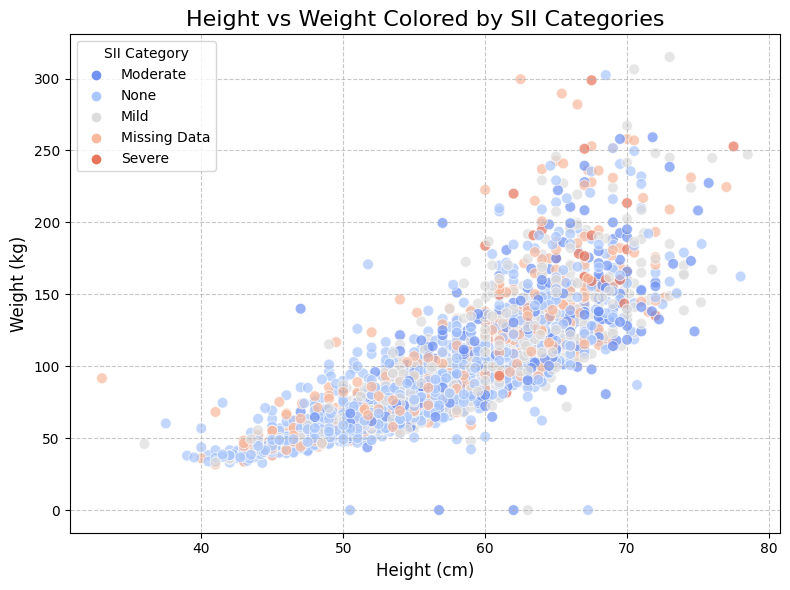

In [26]:
# Scatter plot for height vs weight, colored by SII Category
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Physical-Height', 
    y='Physical-Weight', 
    hue='SII_Category', 
    data=train, 
    palette='coolwarm', 
    alpha=0.7, 
    s=60
)
plt.title("Height vs Weight Colored by SII Categories", fontsize=16)
plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Weight (kg)", fontsize=12)
plt.legend(title="SII Category", loc='upper left', fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


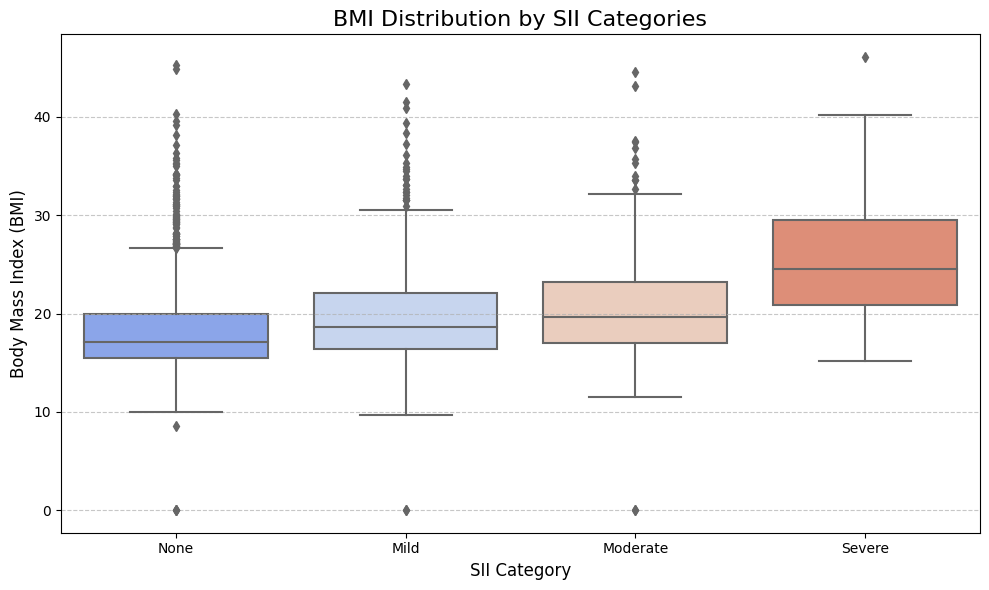

In [27]:
# Plot BMI distribution across SII Categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='SII_Category', y='Physical-BMI', data=train, 
            order=["None", "Mild", "Moderate", "Severe"], palette='coolwarm')
plt.title("BMI Distribution by SII Categories", fontsize=16)
plt.xlabel("SII Category", fontsize=12)
plt.ylabel("Body Mass Index (BMI)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


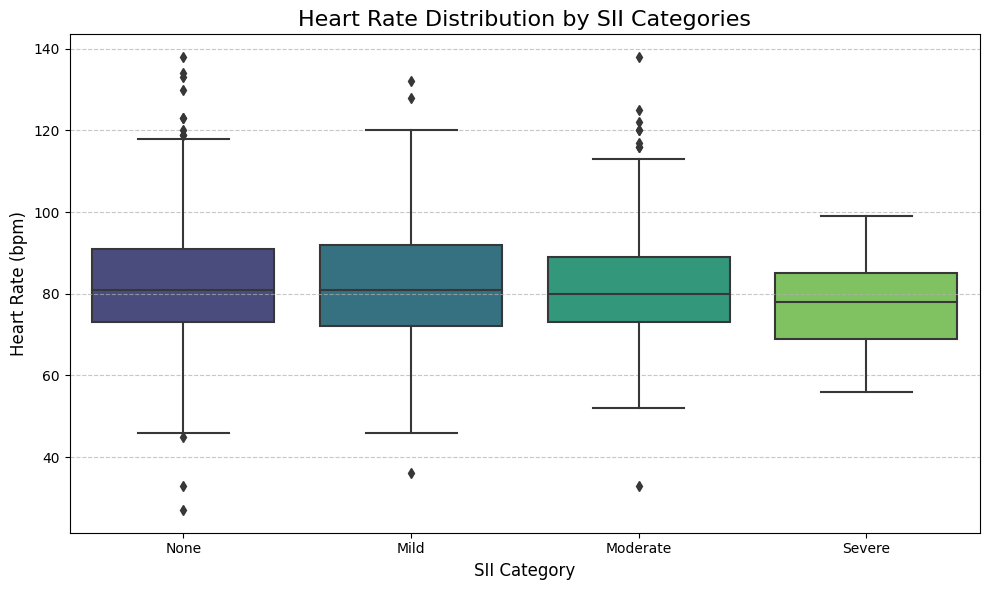

In [28]:
# Boxplot for heart rate across SII categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='SII_Category', y='Physical-HeartRate', data=train, 
            order=["None", "Mild", "Moderate", "Severe"], palette='viridis')
plt.title("Heart Rate Distribution by SII Categories", fontsize=16)
plt.xlabel("SII Category", fontsize=12)
plt.ylabel("Heart Rate (bpm)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Correlation of Physical Measures with SII:
Physical-BMI          0.221125
Physical-Height       0.373530
Physical-Weight       0.325938
Physical-HeartRate   -0.024572
Name: sii, dtype: float64


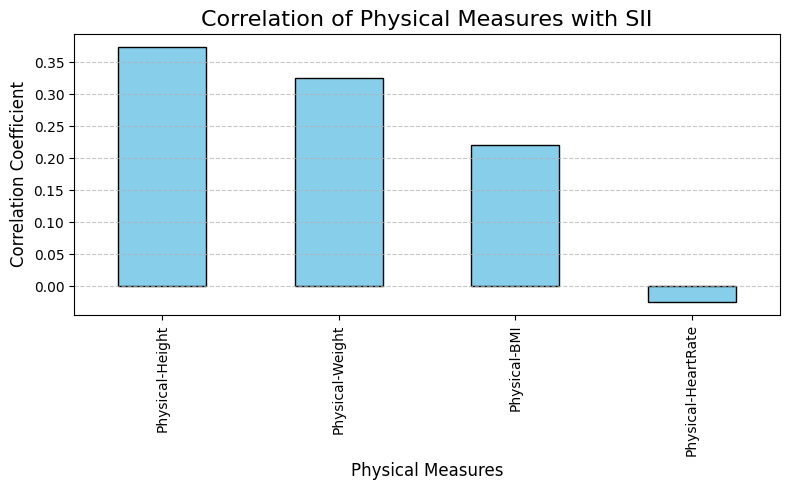

In [29]:
# Select physical measure columns
physical_measures = ['Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-HeartRate']

# Calculate correlation of physical measures with SII
correlations = train[physical_measures + ['sii']].corr()['sii'].drop('sii')
print("Correlation of Physical Measures with SII:")
print(correlations)

# Plot correlations
plt.figure(figsize=(8, 5))
correlations.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Correlation of Physical Measures with SII", fontsize=16)
plt.xlabel("Physical Measures", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


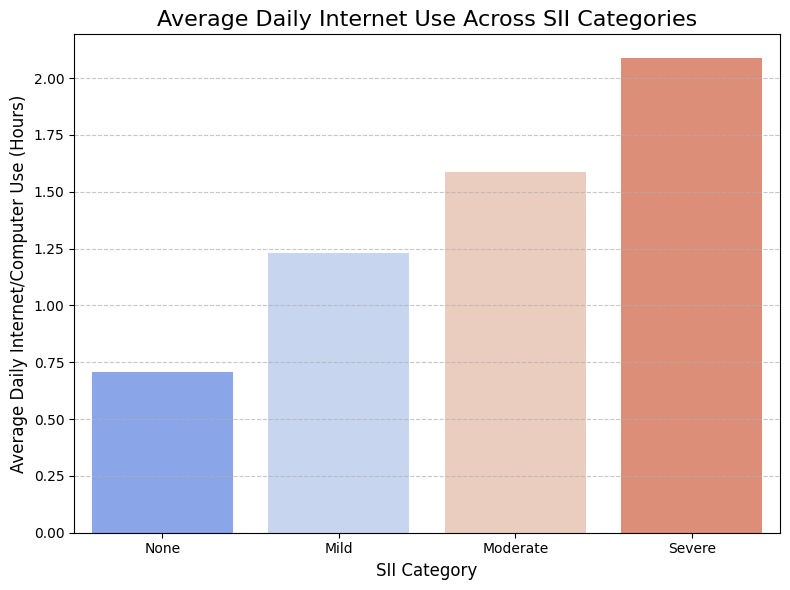

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure SII_Category exists and is properly mapped
if 'SII_Category' not in train.columns:
    sii_map = {
        0: "None",
        1: "Mild",
        2: "Moderate",
        3: "Severe",
        "missing": "Missing Data"
    }
    train['sii_filled'] = train['sii'].fillna("missing")
    train['SII_Category'] = train['sii_filled'].map(sii_map)

# Handle missing values in the internet usage column
if train['PreInt_EduHx-computerinternet_hoursday'].isnull().sum() > 0:
    train['PreInt_EduHx-computerinternet_hoursday'] = train['PreInt_EduHx-computerinternet_hoursday'].fillna(0)

# Calculate the mean daily internet usage per SII category
internet_usage_means = train.groupby('SII_Category')['PreInt_EduHx-computerinternet_hoursday'].mean()

# Bar chart to show internet usage across SII levels
plt.figure(figsize=(8, 6))
sns.barplot(
    x=internet_usage_means.index,
    y=internet_usage_means.values,
    order=["None", "Mild", "Moderate", "Severe"],
    palette='coolwarm'
)
plt.title("Average Daily Internet Use Across SII Categories", fontsize=16)
plt.xlabel("SII Category", fontsize=12)
plt.ylabel("Average Daily Internet/Computer Use (Hours)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


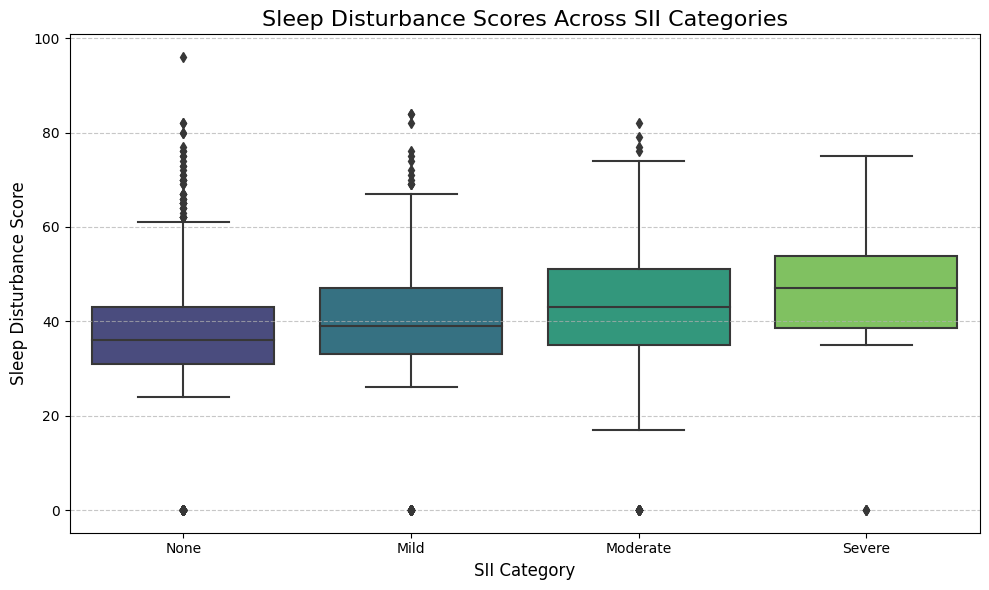

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure SII_Category exists and is properly mapped
if 'SII_Category' not in train.columns:
    sii_map = {
        0: "None",
        1: "Mild",
        2: "Moderate",
        3: "Severe",
        "missing": "Missing Data"
    }
    train['sii_filled'] = train['sii'].fillna("missing")
    train['SII_Category'] = train['sii_filled'].map(sii_map)

# Handle missing values in sleep disturbance scores
if train['SDS-SDS_Total_Raw'].isnull().sum() > 0:
    train['SDS-SDS_Total_Raw'] = train['SDS-SDS_Total_Raw'].fillna(0)

# Boxplot for sleep disturbance score across SII levels
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='SII_Category',
    y='SDS-SDS_Total_Raw',
    data=train,
    order=["None", "Mild", "Moderate", "Severe"],
    palette='viridis'
)
plt.title("Sleep Disturbance Scores Across SII Categories", fontsize=16)
plt.xlabel("SII Category", fontsize=12)
plt.ylabel("Sleep Disturbance Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Feature Engineering

In [5]:


def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test_ids = test["id"]
test = test.drop('id', axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

# Save processed train and test datasets to CSV
train.to_csv('/kaggle/working/processed_train.csv', index=False)
test.to_csv('/kaggle/working/processed_test.csv', index=False)

print("Processed data saved to CSV!")


100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


Train Shape : (2736, 155) || Test Shape : (20, 154)
Processed data saved to CSV!


## Handling Missing Values

In [6]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming `train` and `test` are your dataframes
# Define features dynamically
num_features = [f for f in train.columns if train[f].dtype in ['float64', 'int64']]
cat_features = [f for f in train.columns if f not in num_features]

# Exclude 'sii' (target) column from numerical features
if 'sii' in num_features:
    num_features.remove('sii')

print('The number of numerical features:', len(num_features))
print('The number of categorical features:', len(cat_features))

# Ensure the test set has all numerical and categorical features from train
missing_numerical_in_test = [col for col in train.columns if col not in test.columns and col in num_features]
for col in missing_numerical_in_test:
    test[col] = None  # Add missing numerical columns with NaN values

missing_categorical_in_test = [col for col in train.columns if col not in test.columns and col in cat_features]
for col in missing_categorical_in_test:
    test[col] = 'unknown'  # Add missing categorical columns with placeholder values

# Impute numerical features for train
imputer_num = KNNImputer(n_neighbors=2, weights="uniform")
train[num_features] = imputer_num.fit_transform(train[num_features])  # Fit and transform on train

# Use the same imputer for test
test[num_features] = imputer_num.transform(test[num_features])  # Transform on test

# Handle categorical features for train
for col in cat_features:
    train[col] = train[col].fillna('unknown')  # Fill missing values with 'unknown'
    train[col] = train[col].astype('category')  # Convert to categorical

# Handle categorical features for test
for col in cat_features:
    test[col] = test[col].fillna('unknown')  # Fill missing values with 'unknown'
    test[col] = test[col].astype('category')  # Convert to categorical

# Verify missing values in both datasets
print("Train missing values after imputation:", train.isnull().sum().sum())
print("Test missing values after imputation:", test.isnull().sum().sum())


The number of numerical features: 154
The number of categorical features: 0
Train missing values after imputation: 0
Test missing values after imputation: 0


## Handling Class Distribution

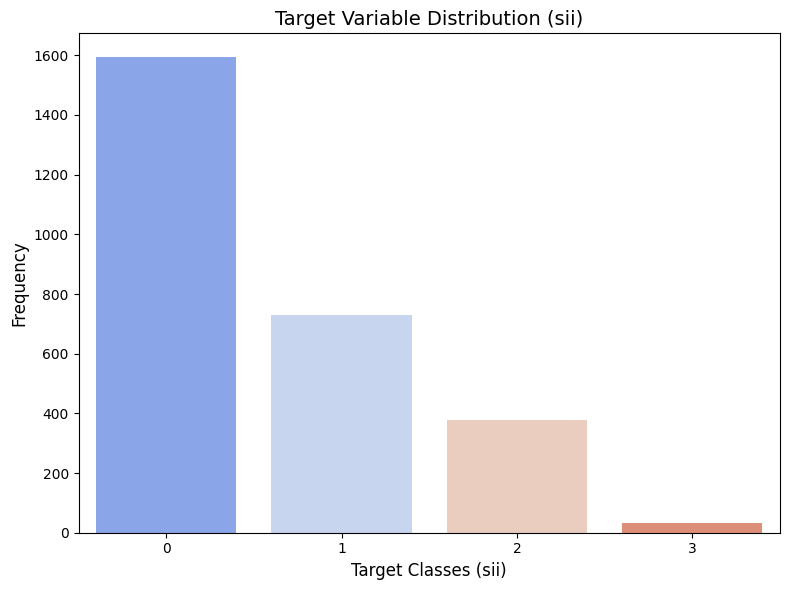

Target Class Distribution:
sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check target distribution in the training data
plt.figure(figsize=(8, 6))
sns.countplot(x=train['sii'], palette="coolwarm")
plt.title("Target Variable Distribution (sii)", fontsize=14)
plt.xlabel("Target Classes (sii)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=["0", "1", "2", "3"])
plt.tight_layout()
plt.show()

# Print exact counts of each class
print("Target Class Distribution:")
print(train['sii'].value_counts())


##  Borderline-SMOTE

In [8]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split

def apply_borderline_smote(X, y, random_state=42):
    """
    Applies Borderline-SMOTE to balance the dataset.

    Args:
        X (pd.DataFrame or np.ndarray): Features.
        y (pd.Series or np.ndarray): Target values.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_resampled (np.ndarray): Resampled features.
        y_resampled (np.ndarray): Resampled target values.
    """
    smote = BorderlineSMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled


# Example usage
X = train.drop(columns=["sii"])  # Features
y = train["sii"].astype(int)     # Target

# Split the dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply Borderline-SMOTE
X_train_resampled, y_train_resampled = apply_borderline_smote(X_train, y_train)

# Now you can use X_train_resampled and y_train_resampled for further model training
print(f"Original training samples: {len(y_train)}, Resampled training samples: {len(y_train_resampled)}")


Original training samples: 2188, Resampled training samples: 5100
